cesar.shimura@gmail.com  
January 2023 - Source: HLTV

**Objective:**  
This notebook analyzes Imperial's performance during 2022. Imperial Esports is a Brazilian professional CSGO team that gained notoriety last year after FalleN announced his Last Dance project. After several tournaments and changes of players during 2022, this notebook seeks to bring any insight on Imperial's performance.

## Data Importing, Cleaning and Transforming

In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Importing dataframe

df = pd.read_csv('csgo_imperial_v5.csv')

In [3]:
# Checking dataframe

df.head()

,Unnamed: 0,team_1,team_2,bo3_result,date,championship,map,score_1,score_2,players_t1,players_t2,kd_t1,kd_t2
0,0,Imperial,00NATION,2 - 0,Results for January 20th 2023,ESL Pro League Season 17 Conference South America,Nuke,16,3,chelo,dumau,25-12,8-16
1,1,Imperial,00NATION,2 - 0,Results for January 20th 2023,ESL Pro League Season 17 Conference South America,Nuke,16,3,VINI,nqz,21-8,10-15
2,2,Imperial,00NATION,2 - 0,Results for January 20th 2023,ESL Pro League Season 17 Conference South America,Nuke,16,3,FalleN,coldzera,13-5,11-19
3,3,Imperial,00NATION,2 - 0,Results for January 20th 2023,ESL Pro League Season 17 Conference South America,Nuke,16,3,JOTA,TACO,13-9,8-18
4,4,Imperial,00NATION,2 - 0,Results for January 20th 2023,ESL Pro League Season 17 Conference South America,Nuke,16,3,boltz,latto,12-9,6-17


In [4]:
# Checking dataframe

df.shape

(890, 13)

In [5]:
# Deleting column Unnamed

df.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
# Changing column date to datetime format

df['day'] = df['date'].apply(lambda x:x.split()[-2])
df['month'] = df['date'].apply(lambda x:x.split()[-3])
df['year'] = df['date'].apply(lambda x:x.split()[-1])

In [7]:
# Adjusting day format

import regex as re

def get_day(nam):
    pattern = '[0-9]+'
    return re.search(pattern, nam).group(0)

df['day'] = df['day'].apply(lambda x:get_day(x))

In [8]:
# Adjusting month format

months = {'January':1,
          'February':2,
          'March':3,
          'April':4,
          'May':5,
          'June':6,
          'July':7,
          'August':8,
          'September':9,
          'October':10,
          'November':11,
          'December':12}

month_df = pd.DataFrame(months, index = ['month_value']).transpose().reset_index().rename(columns = {'index':'month'})

df = pd.merge(df,month_df, on = 'month', how = 'left')

df.drop('month', axis = 1, inplace = True)
df.rename(columns = {'month_value':'month'}, inplace = True)

In [9]:
# Creating adjusted new date column

df.drop('date', axis = 1, inplace = True)

df['date'] = pd.to_datetime(df[['year','month','day']])

In [10]:
# Dropping used day, month and year columns

df.drop(['day', 'month', 'year'], axis = 1, inplace = True)

In [11]:
# Separating kd to count kills and deaths from each player

df['k_t1'] = df['kd_t1'].apply(lambda x:int(x.split('-')[0]))
df['d_t1'] = df['kd_t1'].apply(lambda x:int(x.split('-')[1]))
df['k_t2'] = df['kd_t2'].apply(lambda x:int(x.split('-')[0]))
df['d_t2'] = df['kd_t2'].apply(lambda x:int(x.split('-')[1]))


# Droping old columns

df.drop(['kd_t1', 'kd_t2'], axis = 1, inplace = True)

In [12]:
# Unifying maps names

def change_maps(nam):
    if nam == 'inf':
        return 'Inferno'
    elif nam == 'mrg':
        return 'Mirage'
    elif nam == 'nuke':
        return 'Nuke'
    elif nam == 'ovp':
        return 'Overpass'
    elif nam == 'd2':
        return 'Dust2'
    elif nam == 'vtg':
        return 'Vertigo'
    else:
        return nam
    
df['map'] = df['map'].apply(lambda x:change_maps(x))

In [13]:
# Creating a date to filter the period for this analysis.
# FalleN joined Imperial to create the Last Dance Project from March 4th until the end of 2022.

date_filter = datetime.datetime(2022,3,4)


# Separating a new dataframe only with the matches played with the new team from 2022

df_f = df[(df['date']>=date_filter) & (df['date']<datetime.datetime(2023,1,1))].copy()

In [14]:
# Reseting indexes

df_f.reset_index(drop = True, inplace = True)

In [15]:
# Creating a new column to classify whether Imperial played bo3 or a single map

def bo3_smap(nam):
    if pd.isnull(nam) == True:
        return 'single map'
    else:
        return 'best of 3'
    
df_f['match'] = df_f['bo3_result'].apply(lambda x:bo3_smap(x))

In [16]:
# For bo3, creating column that sums the number of maps played

def num_maps(nam):
    if pd.isnull(nam):
        pass
    else:
        return int(nam.split(' - ')[0]) + int(nam.split(' - ')[1])

df_f.loc[:,'num_maps'] = df_f['bo3_result'].apply(lambda x:num_maps(x))

In [17]:
# Creating a new column to signal whether Imperial won the map or not

map_won = []

for i in np.arange(len(df_f['score_1'])):
    if df_f['score_1'].iloc[i] > df_f['score_2'].iloc[i]:
        map_won.append(1)
    else:
        map_won.append(0)
    
df_f['map_won'] = map_won

In [18]:
# Creating new column to signal whether Imperial won the bo3 match

def bo3_won(nam):
    if pd.isnull(nam) == True:
        pass
    elif nam == '0 - 2':
        return 0
    elif nam == '1 - 2':
        return 0
    elif nam == '2 - 0':
        return 1
    elif nam == '2 - 1':
        return 1
    else:
        pass
    
df_f['bo3_won'] = df_f['bo3_result'].apply(lambda x:bo3_won(x))

In [19]:
# Creating a new column to calculate the score difference

df_f['score_diff'] = df_f['score_1'] - df_f['score_2']

In [20]:
# Creating a new column to calculate the difference of kills and deaths of Imperial and opponent team

df_f['kd_t1'] = df_f['k_t1']-df_f['d_t1']
df_f['kd_t2'] = df_f['k_t2']-df_f['d_t2']

### Checking dataframe columns

In [21]:
df_f.dtypes # Checking value types

team_1                  object
team_2                  object
bo3_result              object
championship            object
map                     object
score_1                  int64
score_2                  int64
players_t1              object
players_t2              object
date            datetime64[ns]
k_t1                     int64
d_t1                     int64
k_t2                     int64
d_t2                     int64
match                   object
num_maps               float64
map_won                  int64
bo3_won                float64
score_diff               int64
kd_t1                    int64
kd_t2                    int64
dtype: object

In [22]:
df_f['team_1'].unique() # team_1 should only have Imperial since that's how data was extracted it.

array(['Imperial'], dtype=object)

In [23]:
"Imperial" in df_f['team_2'].unique() # team_2 should only have Imperial's opponents.

False

In [24]:
df_f['bo3_result'].value_counts() # bo3_result should contain bo3 results

1 - 2    120
2 - 0    120
2 - 1    120
0 - 2     80
Name: bo3_result, dtype: int64

In [25]:
df_f['championship'].value_counts() # championship should name all tournaments from 2022

IEM Road to Rio 2022 Americas RMR                               65
IEM Dallas 2022 South America Closed Qualifier                  50
ESL Challenger Melbourne 2022                                   45
PGL Major Antwerp 2022                                          45
OMEN WGR European Challenge 2022                                40
FiReLEAGUE Latin Power Spring 2022 - BLAST Premier Qualifier    40
PGL Major Antwerp 2022 Challengers Stage                        40
PGL Major Antwerp 2022 Americas RMR                             40
IEM Cologne 2022 Play-In                                        30
Pinnacle Cup Championship 2022                                  30
PGL Major Antwerp 2022 Americas RMR SA Open Qualifier 1         25
Roobet Cup 2022                                                 25
REPUBLEAGUE Season 3                                            25
Flow FiReLEAGUE 2022 Global Finals                              25
IEM Rio Major 2022 Challengers Stage                          

In [26]:
df_f['map'].unique() # map should contain all maps played by Imperial in 2022

array(['Overpass', 'Vertigo', 'Dust2', 'Inferno', 'Nuke', 'Mirage',
       'Ancient'], dtype=object)

In [27]:
df_f[['score_1', 'score_2']].describe() # Checking tha max value for the score. Since both max scores are 25, it is right.

,score_1,score_2
count,575.000000,575.000000
mean,14.182609,13.321739
std,3.921225,4.939614
min,2.000000,2.000000
25%,11.000000,10.000000
50%,16.000000,16.000000
75%,16.000000,16.000000
max,25.000000,25.000000


In [28]:
df_f['players_t1'].unique() # Checking whether players_t1 only contains players from Imperial

array(['fer', 'VINI', 'chelo', 'FalleN', 'boltz', 'fnx'], dtype=object)

In [29]:
df_f[['k_t1','d_t1','k_t2','d_t2']].describe() # Checking map kd to check any discrepancy. k_t1 and d_t1 reffer to Imperial players' kd

,k_t1,d_t1,k_t2,d_t2
count,575.000000,575.000000,575.000000,575.000000
mean,18.219130,17.438261,17.365217,18.314783
std,6.079094,5.174576,6.513896,4.486919
min,4.000000,5.000000,4.000000,3.000000
25%,14.000000,14.000000,13.000000,16.000000
50%,18.000000,17.000000,17.000000,18.000000
75%,22.000000,20.000000,21.000000,20.000000
max,43.000000,39.000000,45.000000,36.000000


## Analysis of Imperial Performance

### 1. How many matches did Imperial play? Both single maps (bo1) and best of 3 (bo3).

In [30]:
# Calculating number of best of 3 matches played 

num_matches = pd.pivot_table(df_f, index = ['team_1','bo3_result'], values = 'num_maps', aggfunc = ['count','mean'])

num_matches = num_matches.stack().reset_index(drop=True)

num_matches['matches'] = (num_matches['count']/num_matches['mean'])/5

total_bo3 = num_matches['matches'].sum()
print(total_bo3)

36.0


In [31]:
# Calculating number of single maps played (best of 1)

bo1 = df_f['match'].value_counts()/5
total_bo1 = bo1['single map']
print(total_bo1)

27.0


In [32]:
# Total number of matches in 2022

total_bo3 + total_bo1

63.0

In [33]:
# Divison of matches:

print(f'From {total_bo3+total_bo1:.0f} matches, {total_bo3:.0f} were bo3 ({100*(total_bo3/(total_bo3+total_bo1)):.0f}%)')
print(f'From {total_bo3+total_bo1:.0f} matches, {total_bo1:.0f} were bo1 ({100*(total_bo1/(total_bo3+total_bo1)):.0f}%)')

From 63 matches, 36 were bo3 (57%)
From 63 matches, 27 were bo1 (43%)


> * In 2022, Imperial played a total of 63 matches (bo1 and bo3).  
> * More than half of the matches played in 2022 was best of 3 (57%).  
> * Considering that Imperial played for 8 months (from March until November with exception of August), the team played an average of almost 8 matches in each month.

### 2. How many matches did Imperial win? Both single maps and best of 3.  

In [34]:
# Number of bo3 matches won

num_won = pd.pivot_table(df_f,index=['team_2','bo3_result'], values = ['bo3_won','num_maps'], aggfunc={'bo3_won':np.sum, 'num_maps':np.mean})

num_won.reset_index(drop=True, inplace = True)

num_won['match_won'] = (num_won['bo3_won']/5)/num_won['num_maps']

won_bo3 = num_won['match_won'].sum()
print(won_bo3)

20.0


In [35]:
# Number of single maps (best of 1) won

won_bo1 = sum(df_f[df_f['match'] == 'single map']['score_1']>df_f[df_f['match'] == 'single map']['score_2'])/5
print(won_bo1)

13.0


In [36]:
# Total number of matches won in 2022

won_bo3 + won_bo1

33.0

In [37]:
# % of matches won

print(f'From {total_bo3 + total_bo1} matches played in 2022, Imperial won {won_bo3 + won_bo1} ({((won_bo3 + won_bo1)/(total_bo3 + total_bo1))*100:.0f}%)')

From 63.0 matches played in 2022, Imperial won 33.0 (52%)


In [38]:
# % of matches won from bo3

print(f'From {total_bo3} bo3 matches played in 2022, Imperial won {won_bo3} ({((won_bo3)/(total_bo3))*100:.0f}%)')

From 36.0 bo3 matches played in 2022, Imperial won 20.0 (56%)


In [39]:
# % of matches won from bo1

print(f'From {total_bo1} bo1 matches played in 2022, Imperial won {won_bo1} ({((won_bo1)/(total_bo1))*100:.0f}%)')

From 27.0 bo1 matches played in 2022, Imperial won 13.0 (48%)


> * From all matches played in 2022, half of them Imperial won.
> * Imperial won more bo3 matches (20 out of 36) compared to bo1 (13 out of 27).

### 3. How many maps did Imperial play on? What were they? 

In [40]:
# Total maps played

total_map = sum(df_f['map'].value_counts()/5)
print(total_map)

115.0


In [41]:
# Maps played

maps_played = df_f['map'].value_counts()/5
print(maps_played)

Inferno     27.0
Overpass    24.0
Nuke        19.0
Dust2       16.0
Mirage      16.0
Vertigo     12.0
Ancient      1.0
Name: map, dtype: float64


In [42]:
# Maps played (in %)

maps_played_perc = df_f['map'].value_counts(normalize=True)
print(maps_played_perc)

Inferno     0.234783
Overpass    0.208696
Nuke        0.165217
Dust2       0.139130
Mirage      0.139130
Vertigo     0.104348
Ancient     0.008696
Name: map, dtype: float64


<Figure size 400x100 with 0 Axes>

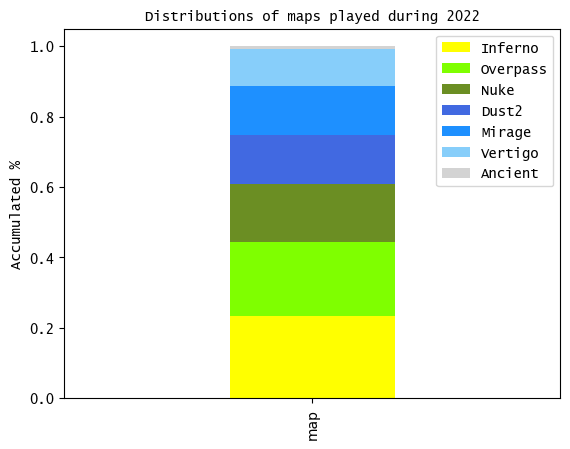

In [43]:
# Maps played

plt.figure(figsize = (4,1))

pd.DataFrame(maps_played_perc).transpose().plot(kind = 'bar', stacked = True, width = 0.25, color = ['yellow','chartreuse','olivedrab','royalblue','dodgerblue','lightskyblue','lightgrey'])

plt.title('Distributions of maps played during 2022', font = 'Lucida Console')
plt.ylabel('Accumulated %', font = 'Lucida Console')
plt.yticks(font = 'Lucida Console')
plt.legend(prop = {'family':'Lucida Console'})
plt.show()

> * Inferno, Overpass and Nuke represented 60% of the maps played, followed by Dust2 and Mirage (almost 30%) and Vertigo and Ascient.

### 4. How many maps did Imperial win? What were they?  

In [44]:
# Number of maps won

won_map = df_f['map_won'].sum()/5
print(won_map)

61.0


In [45]:
# Maps won by map

maps_won = pd.pivot_table(df_f, index = 'map', values = 'map_won', aggfunc = 'sum')/5
print(maps_won)

          map_won
map              
Ancient       0.0
Dust2         8.0
Inferno      17.0
Mirage        8.0
Nuke          9.0
Overpass     17.0
Vertigo       2.0


In [46]:
# Comparison of maps won and played

maps_results = pd.merge(maps_played.rename('played'), maps_won, left_index=True, right_index=True, how = 'outer')
maps_results['%'] = maps_results['map_won']/maps_results['played']
maps_results.sort_values(by = '%',ascending=False)

,played,map_won,%
Overpass,24.0,17.0,0.708333
Inferno,27.0,17.0,0.629630
Dust2,16.0,8.0,0.500000
Mirage,16.0,8.0,0.500000
Nuke,19.0,9.0,0.473684
Vertigo,12.0,2.0,0.166667
Ancient,1.0,0.0,0.000000


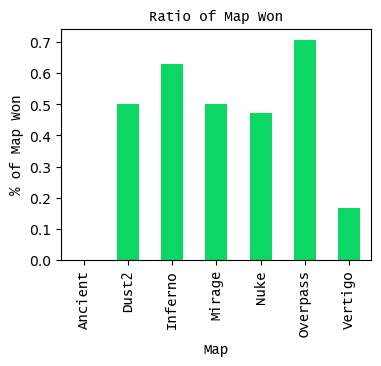

In [47]:
# Plotting comparison of maps won

plt.figure(figsize = (4,3))

maps_results['%'].plot(kind = 'bar', color = '#0CD664')
plt.title('Ratio of Map Won', font = 'Lucida Console')
plt.xlabel('Map',font = 'Lucida Console')
plt.ylabel('% of Map Won', font = 'Lucida Console')
plt.xticks(font = 'Lucida Console')

plt.show()

> * Overpass was the map that Imperial had the highest rate of winning (70%) followed by Inferno (60%). Both maps consisted of almost 45% of all maps played.  
> * Mirage, Nuke and Dust2 had a winning rate 50%, which all three consisted of also almost 45% of all maps played.  
> * Vertigo had the lowest rate of winnig (20%), which consisted of 10% of all maps played.

### 5. What was the final score of maps played?  

In [48]:
# Creating new df to count how many times each difference of score occured

diff_score = pd.DataFrame(df_f['score_diff'].value_counts()/5).reset_index().rename(columns = {'score_diff':'count', 'index':'score_diff'}).sort_values(by = 'score_diff')

In [49]:
change_ax = pd.DataFrame(np.arange(-14,15,1),columns = ['score_diff'])

In [50]:
diff_score_f = pd.merge(diff_score, change_ax, on = 'score_diff', how = 'right').fillna(0)

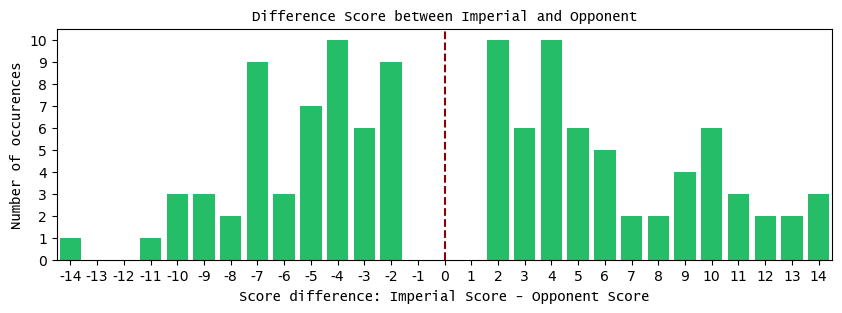

In [51]:
# Plotting diff_score for all maps

plt.figure(figsize = (10,3))
sns.barplot(data = diff_score_f, x = 'score_diff', y = 'count', color = '#0CD664')
plt.title('Difference Score between Imperial and Opponent', font = 'Lucida Console')
plt.xlabel('Score difference: Imperial Score - Opponent Score', font = 'Lucida Console')
plt.yticks(np.arange(0,11))
plt.ylabel('Number of occurences', font = 'Lucida Console')
plt.axvline(14, c = 'darkred', ls = '--')


plt.show()

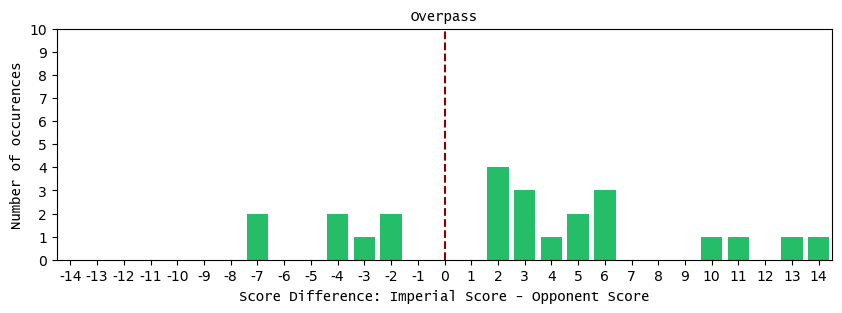

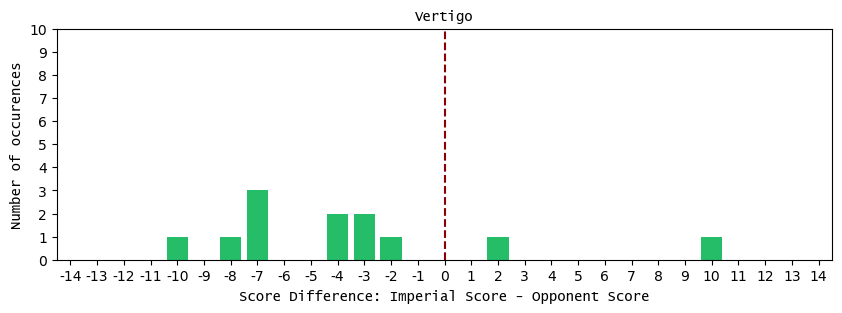

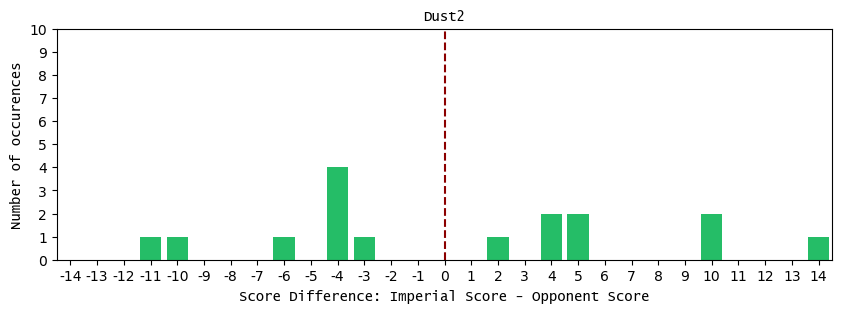

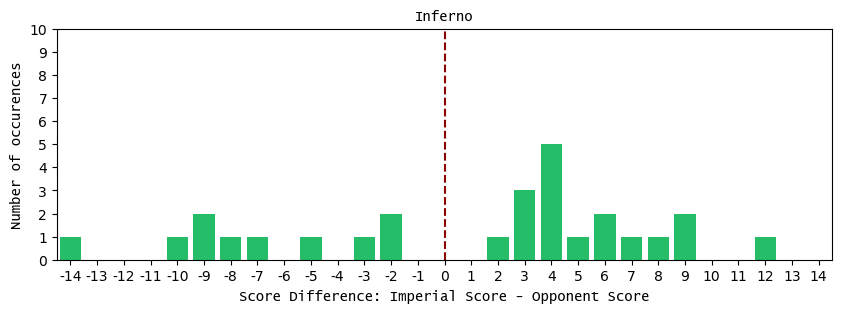

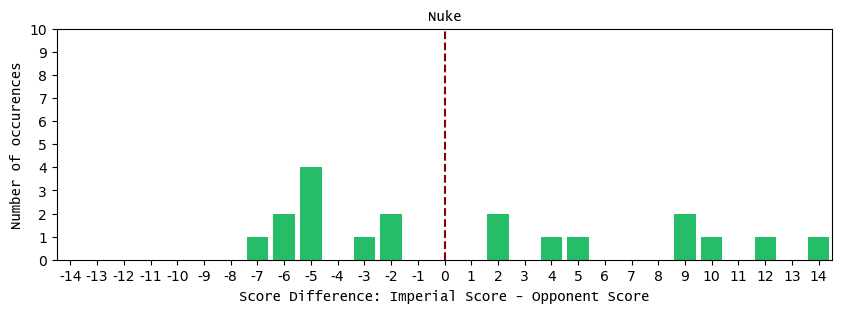

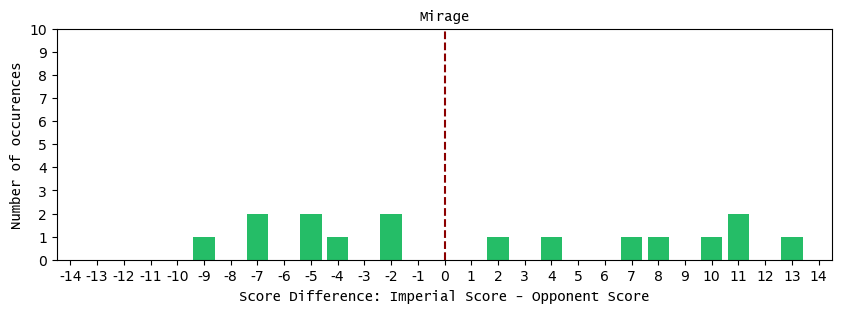

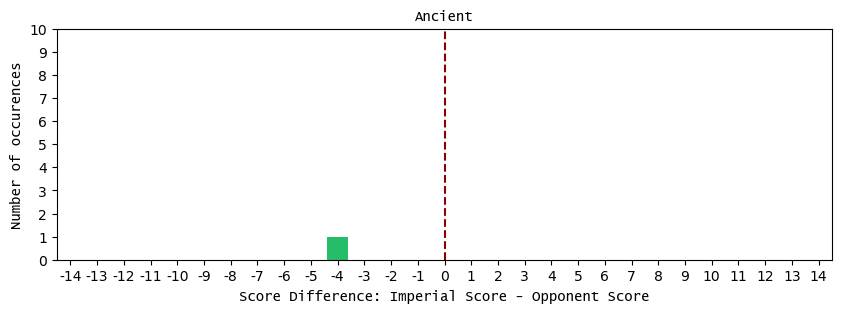

In [52]:
# Plotting diff_score for each map

for nam in df_f['map'].unique():
    diff_score_map = pd.DataFrame(df_f[df_f['map'] == nam]['score_diff'].value_counts()/5).reset_index().rename(columns = {'score_diff':'count', 'index':'score_diff'}).sort_values(by = 'score_diff')
    diff_score_f_map = pd.merge(diff_score_map, change_ax, on = 'score_diff', how = 'right').fillna(0)
    
    plt.figure(figsize = (10,3))
    sns.barplot(data = diff_score_f_map, x = 'score_diff', y = 'count', color = '#0CD664')
    plt.title(nam, font = 'Lucida Console')
    plt.xlabel('Score Difference: Imperial Score - Opponent Score', font = 'Lucida Console')
    plt.yticks(np.arange(0,11))
    plt.ylabel('Number of occurences', font = 'Lucida Console')
    plt.axvline(14, c = 'darkred', ls = '--')
    plt.show()

> * Score difference seems balance, mainly concentrating in the range from -4 to +4.
> * There were 3 maps on Vertigo in which Imperial lost with -7 difference that contributed for the spike on the graph.

### 6. What was Imperial overall kill-death (kd) performance (total and by map)?  

In [53]:
# Imperial sum of kills

total_k = df_f['k_t1'].sum()
print(total_k)

10476


In [54]:
# Imperial sum of deaths

total_d = df_f['d_t1'].sum()
print(total_d)

10027


In [55]:
# Overall kd-ratio in 2022

total_k/total_d

1.044779096439613

In [56]:
# Calculating total kd in each map

map_kd =  pd.pivot_table(data = df_f, index = 'map', values = ['k_t1', 'd_t1'], aggfunc = 'sum')
map_kd['diff'] = map_kd['k_t1'] - map_kd['d_t1']

map_kd_f = pd.merge(map_kd, maps_played, how = 'inner', left_on='map', right_index=True).rename(columns = {'map':'count'})

map_kd_f['mean_kd'] = map_kd_f['diff']/map_kd_f['count']

map_kd_f.sort_values(by = 'mean_kd', ascending=False)

,d_t1,k_t1,diff,count,mean_kd
map,,,,,
Nuke,1574,1752,178,19.0,9.368421
Overpass,2191,2369,178,24.0,7.416667
Mirage,1333,1427,94,16.0,5.875000
Inferno,2234,2349,115,27.0,4.259259
Dust2,1418,1440,22,16.0,1.375000
Vertigo,1184,1058,-126,12.0,-10.500000
Ancient,93,81,-12,1.0,-12.000000


In [57]:
df_f['kdratio_t1'] = df_f['k_t1']/df_f['d_t1']

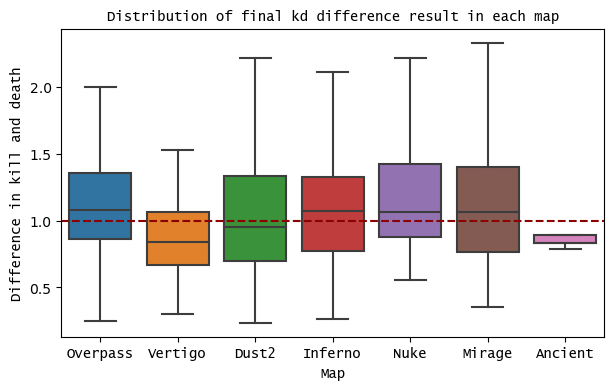

In [58]:
# Calculating kd map distribution

plt.figure(figsize = (7,4))

sns.boxplot(data = df_f, x = 'map', y = 'kdratio_t1',showfliers = False)
plt.axhline(1, c = 'darkred', ls = '--')

plt.title('Distribution of final kd difference result in each map', font = 'Lucida Console')
plt.xlabel('Map', font = 'Lucida Console')
plt.xticks(font = 'Lucida Console')
plt.ylabel('Difference in kill and death', font = 'Lucida Console')
plt.show()

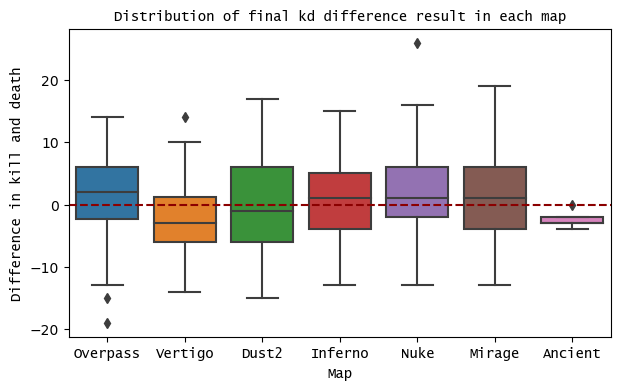

In [59]:
# Calculating kd map distribution

plt.figure(figsize = (7,4))

sns.boxplot(data = df_f, x = 'map', y = 'kd_t1')
plt.axhline(0, c = 'darkred', ls = '--')

plt.title('Distribution of final kd difference result in each map', font = 'Lucida Console')
plt.xlabel('Map', font = 'Lucida Console')
plt.xticks(font = 'Lucida Console')
plt.ylabel('Difference in kill and death', font = 'Lucida Console')
plt.show()

> * In 2022, Imperial's overall kd-ration was 1.04, summing 10.4k kills and 10.0k deaths.  
> * By analyzing the map average performance of the difference between kills and deaths:
>  * Although Imperial team finishes with an average kd difference of +9 on the map Nuke, team's winning rate is around 50%.
>  * Highest winning rate of Overpass and Inferno not necessarily implies highest average kd difference on those maps.

### 7. What was Imperial player kill-death (kd) performance (total and by map)?  

In [60]:
# Overall kd per player

players_total_kd = pd.pivot_table(data = df_f, index = 'players_t1', values = ['k_t1', 'd_t1'], aggfunc = 'sum').reindex(['k_t1','d_t1'], axis = 1)

In [61]:
# Calculating ratio

players_total_kd['ratio'] = players_total_kd['k_t1']/players_total_kd['d_t1']

In [62]:
# Overall kd-ratio per player

players_total_kd.sort_values(by='ratio',ascending=False)

,k_t1,d_t1,ratio
players_t1,,,
FalleN,2142,1876,1.141791
fer,2327,2093,1.111801
chelo,676,615,1.099187
boltz,2049,1964,1.043279
VINI,2039,2050,0.994634
fnx,1243,1429,0.869839


Text(0, 0.5, 'Difference in kill and death')

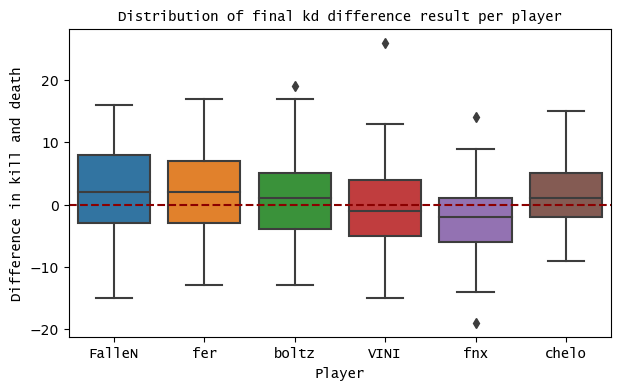

In [63]:
# Calculating kd player distribution

plt.figure(figsize = (7,4))
sns.boxplot(data = df_f, x = 'players_t1', y = 'kd_t1', order = ['FalleN', 'fer', 'boltz', 'VINI', 'fnx', 'chelo'])
plt.axhline(0,color = 'darkred', ls = '--')

plt.title('Distribution of final kd difference result per player', font = 'Lucida Console')
plt.xlabel('Player', font = 'Lucida Console')
plt.xticks(font = 'Lucida Console')
plt.ylabel('Difference in kill and death', font = 'Lucida Console')

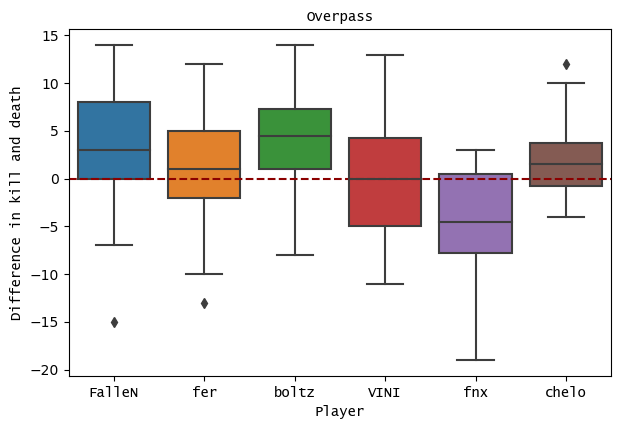

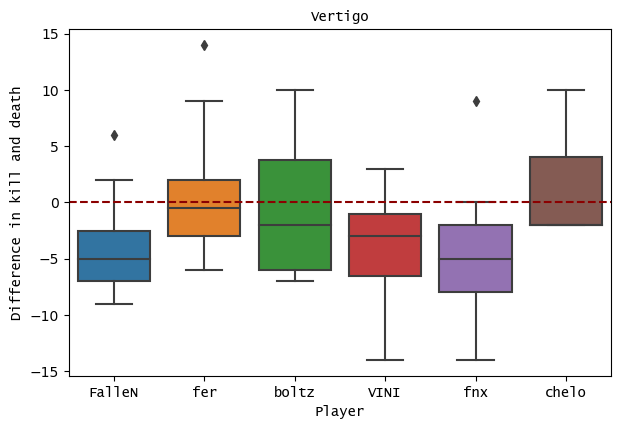

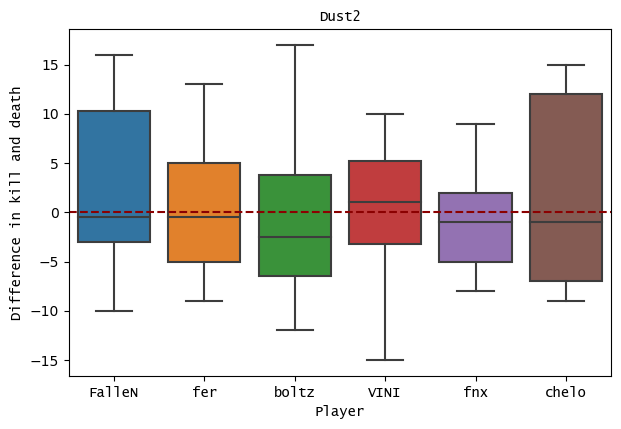

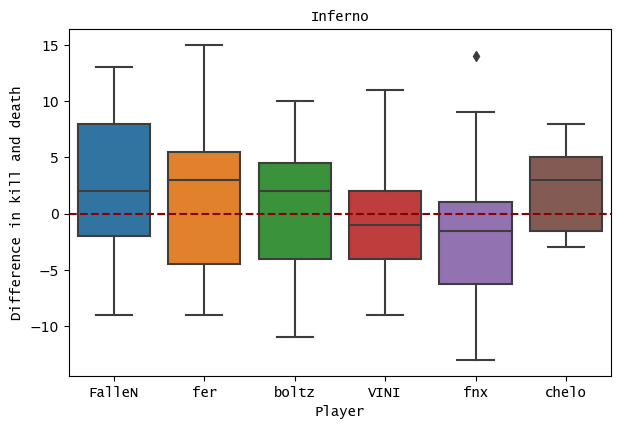

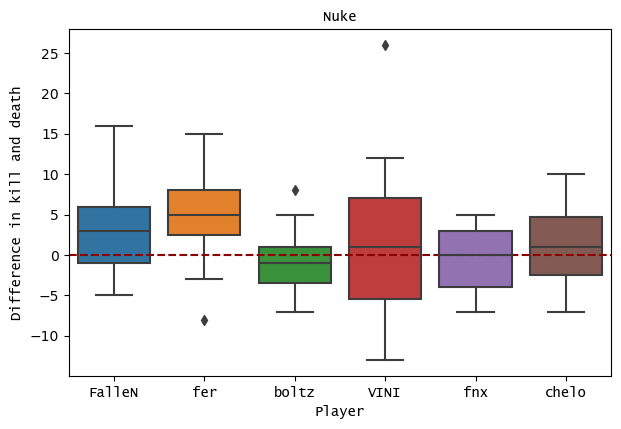

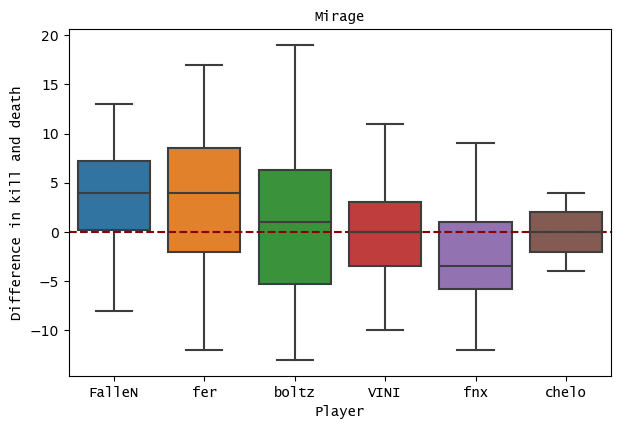

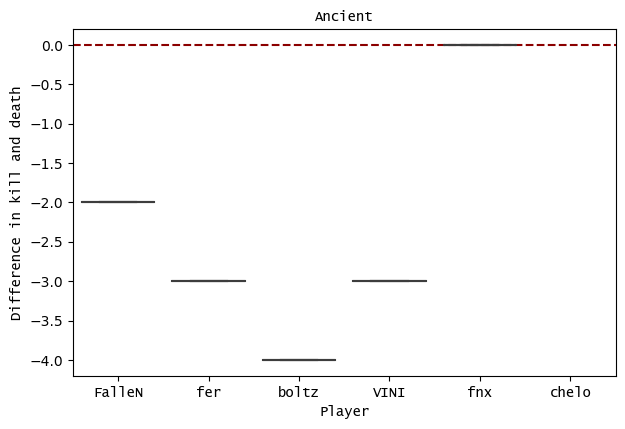

In [64]:
# Calculating kd player distribution in each map

for nam in df_f['map'].unique():
    plt.figure(figsize = (7,4.5))
    sns.boxplot(data = df_f[df_f['map']==nam], x = 'players_t1', y = 'kd_t1', order = ['FalleN', 'fer', 'boltz', 'VINI', 'fnx', 'chelo'])
    plt.axhline(0,color = 'darkred', ls = '--')

    plt.title(nam, font = 'Lucida Console')
    plt.xlabel('Player', font = 'Lucida Console')
    plt.xticks(font = 'Lucida Console')
    plt.ylabel('Difference in kill and death', font = 'Lucida Console')

> * In 2022, by only considering FalleN, fer, boltz and VINI, all players had +2k kills with fer having the highest value (2.3k).
> * Considering total deaths in 2022, FalleN was the one with the lowest value, having the best kd-ratio.
> * Regardless of total result, all four players seemed to have a constant variation of kd difference in all maps played.
> * Dust2, Mirage and Inferno seemed to be the map with the highest variation of kd difference among all players. Specially Inferno, which was a map among the highest winning rate, it seemed that strategy was a more important element than better kd to win this map.
> * Overpass and Nuke were the maps in which players had smaller variations of kd difference, highlighting FalleN and botlz better performance on Overpass and fer on Nuke.

### 8. Better kd implies more wins?

In [65]:
# Creating a df with sum of kills, deaths, kd and whenever Imperial won the map

df_gb = df_f.groupby(['championship','map','team_2','score_1','score_2'])

df_gb_f = df_gb[['k_t1','d_t1','kd_t1','map_won']].sum()

df_gb_f['map_won'] = df_gb_f['map_won']/5

df_gb_f.reset_index(inplace = True)

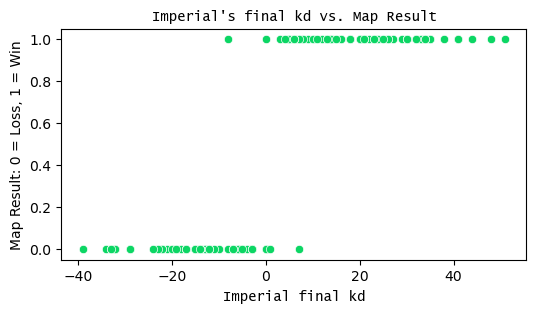

In [66]:
# Plotting final kd and if Imperial won the map

plt.figure(figsize = (6,3))
sns.scatterplot(data = df_gb_f, x = 'kd_t1', y = 'map_won', color = '#0CD664')
plt.title("Imperial's final kd vs. Map Result", font = 'Lucida Console')
plt.xlabel("Imperial final kd", font = 'Lucida Console')
plt.ylabel("Map Result: 0 = Loss, 1 = Win")
plt.show()

In [67]:
# Calculating final score difference

df_gb_f['final_score'] = df_gb_f['score_1'] - df_gb_f['score_2']

<Figure size 1000x400 with 0 Axes>

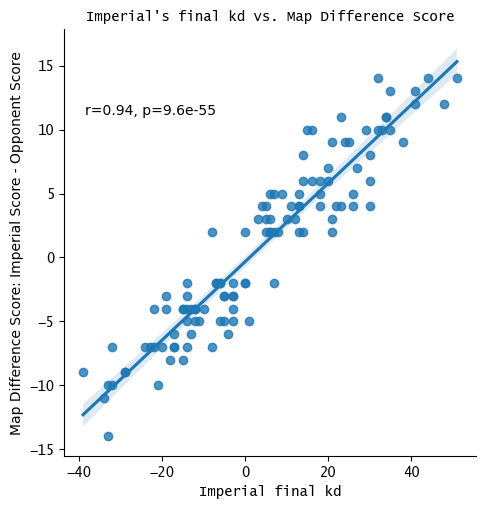

In [68]:
# Plotting final score vs final kd

import scipy as sp

plt.figure(figsize = (10,4))
g = sns.lmplot(data = df_gb_f, x = 'kd_t1', y = 'final_score')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(df_gb_f['final_score'], df_gb_f['kd_t1'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g.map_dataframe(annotate)


plt.title("Imperial's final kd vs. Map Difference Score", font = 'Lucida Console')
plt.xlabel("Imperial final kd", font = 'Lucida Console')
plt.ylabel("Map Difference Score: Imperial Score - Opponent Score")
plt.xticks(font = 'Lucida Console')
plt.yticks(font = 'Lucida Console')
plt.show()

> As expected, better kd results in more wins.